In [2]:
import numpy as np
from scipy.stats import vonmises
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from os.path import join as pjoin
import math


In [10]:
unit = 2
work_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/'
paramspace_dir = pjoin(work_dir, 'anal/unit-selectivity') 

colorspace = np.load(pjoin(paramspace_dir, 'Googlenet_conv2_10color-space.npy'), allow_pickle=True).item()
hue = colorspace['hue']
hue_tuning = colorspace['space'][:,:,:,unit].mean(axis=(1,2))

light = colorspace['light']
light_tuning = colorspace['space'][:,:,:,unit].mean(axis=(0,2))

chroma = colorspace['chroma']
chroma_tuning = colorspace['space'][:,:,:,unit].mean(axis=(0,1))

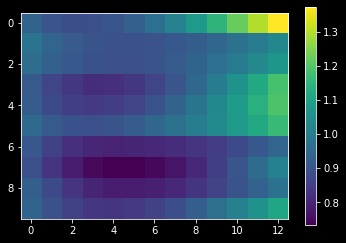

In [11]:
hue_chroma = colorspace['space'][:,:,:,unit].mean(axis=1)
plt.imshow(hue_chroma)
plt.colorbar()
plt.show()

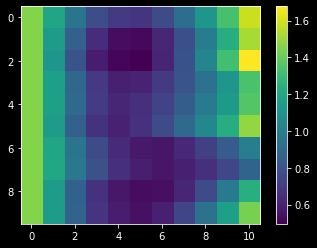

In [12]:
hue_light = colorspace['space'][:,:,:,unit].mean(axis=2)
plt.imshow(hue_light)
plt.colorbar()
plt.show()

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt

def generate_pink_noise(length):
    """ 生成指定长度的粉红噪声 """
    # 创建1/f噪声
    uneven = length % 2
    X = np.random.randn(length // 2 + 1 + uneven) + 1j * np.random.randn(length // 2 + 1 + uneven)
    S = np.concatenate(([X[0].real], X[1:(length // 2 + uneven)].real, [X[-1].real] if uneven else [], X[(length // 2):0:-1].imag))
    y = np.fft.irfft(S, n=length)
    return y

def save_pink_noise_images(num_images, image_size, folder_path):
    """ 生成并保存指定数量的粉红噪声图像 """
    # 确保目标文件夹存在
    os.makedirs(folder_path, exist_ok=True)
    
    for i in range(num_images):
        # 生成粉红噪声
        pink_noise = generate_pink_noise(image_size**2)
        pink_noise_image = pink_noise.reshape((image_size, image_size))
        
        # 创建图像文件路径
        file_path = os.path.join(folder_path, f'pink_noise_{i+1}.png')
        
        # 使用Matplotlib保存图像
        plt.figure(figsize=(6, 6))
        plt.imshow(pink_noise_image, cmap='gray')
        plt.axis('off')  # 不显示坐标轴
        plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
        plt.close()  # 关闭图像，以免占用过多内存

# 参数
N = 227  # 图像尺寸为512x512
num_images = 300  # 要生成的图像数量
folder_path = pjoin(work_dir, 'prep/simplified_stimuli/stim/pinknoise')  # 保存图像的文件夹

save_pink_noise_images(num_images, N, folder_path)


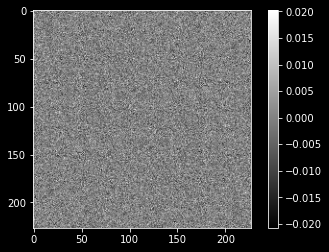

In [15]:
# 显示图像
plt.imshow(pink_noise_image, cmap='gray')
plt.colorbar()
plt.show()

In [1]:
import os
import gc
import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
import statsmodels.api as sm                                                                                        
from os.path import join as pjoin
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import zscore
from joblib import Parallel, delayed
import time
from utils import train_data_normalization, Timer, net_size_info, conv2_labels

In [2]:
sub = 'sub-01'
inputlayername = 'googlenet-conv2' 
layer = {'name': inputlayername, 'size': net_size_info[inputlayername.replace('raw-', '')]}
layername = layer['name']
layername = layername.replace('.','')
labels = conv2_labels
mask_name = 'primaryvis-in-MMP' #'fixretfloc-in-subj'
test_set_name = 'coco'
print(sub, mask_name, layername)
fold_indices = [(0, 1000), (1000, 2000), (2000, 3000), (3000, 4000)]
# path settings
work_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/'
# input path
resp_path = pjoin(work_dir, 'prep/brain_response')
voxel_mask_path = pjoin(work_dir, 'prep/voxel_masks')
image_activations_path = pjoin(work_dir, 'prep/image_activations')
retino_path = pjoin(work_dir, 'build/retinoparams')
guass_path = pjoin(work_dir, 'build/gaussianparams')
performance_path = pjoin(work_dir, 'build/featurewise-corr/conv1-pca-nonlinear')
# save path

sub-01 primaryvis-in-MMP googlenet-conv2


In [19]:
# 准备好刺激激活与噪声值
activ_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/prep/simplified_stimuli/activation'
stim_type =  ['raw_color','pinknoise'] #['color', 'gabor', 'shape']
net_layer = 'Googlenet_conv2'#'Googlenet_maxpool2'

activ_files = sorted([ _ for _ in os.listdir(activ_dir) \
    if f'{net_layer}.npy' in _ and _.replace(f'_{net_layer}.npy', '') in stim_type])
activs = list(map(lambda x: np.load(x, mmap_mode='r'), [pjoin(activ_dir, _) for _ in activ_files]))
print('color  gabor  shape; 三类刺激实验数据')
print(activs[0].shape, activs[1].shape)

color  gabor  shape; 三类刺激实验数据
(300, 64, 56, 56) (396, 64, 56, 56)


In [ ]:
# Define the 2D Gaussian function
def gaussian_2d(coords, A, x_0, y_0, sigma_x, sigma_y,C):
    i, j = coords
    return A * np.exp(-((i - x_0)**2 / (2 * sigma_x**2) + (j - y_0)**2 / (2 * sigma_y**2))) + C

def adjust_RF(receptive_field):
    cur_receptive_field = receptive_field.copy()
    cur_receptive_field = cur_receptive_field + np.abs(np.min(cur_receptive_field, None)) + 1
    thres = np.min(cur_receptive_field) + 0.5*(np.max(cur_receptive_field) - np.min(cur_receptive_field)) #

    cur_receptive_field[cur_receptive_field < thres] = 0
    cur_receptive_field = cur_receptive_field / (cur_receptive_field.sum() + 1e-20)

    return cur_receptive_field

A, x, y, sigma_x, sigma_y, C = 1, 0, 0, 2, 2, 0

fieldsize = activs[0].shape[-1]
i = np.linspace(-8., 8., fieldsize)
j = np.linspace(8., -8., fieldsize)
i, j = np.meshgrid(i, j)
rfmask = adjust_RF(gaussian_2d((i, j), A, x, y, sigma_x, sigma_y, C))